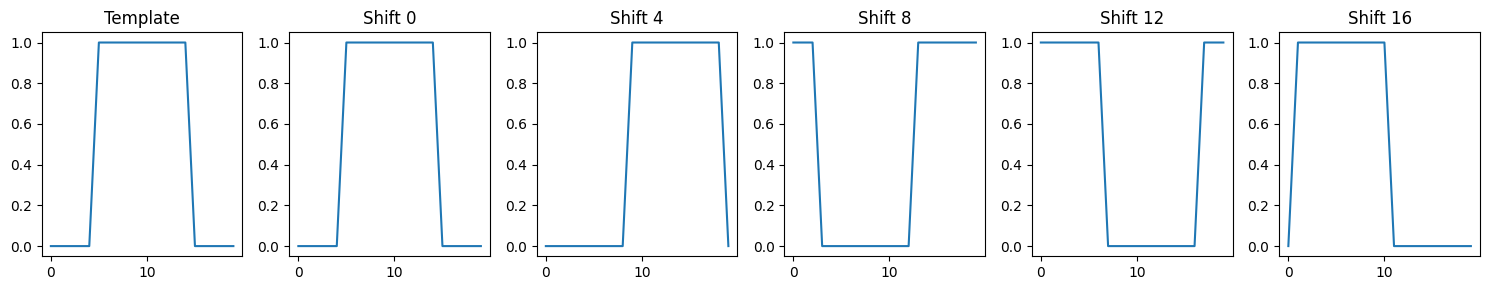

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import itertools

# Generate template array and dataset
n = 20  # Size of array
template = np.zeros(n)
template[n//4:3*n//4] = 1  # Create a box signal

# Generate dataset by rolling
arrays = []
shifts = []
for k in range(n):
    arrays.append(np.roll(template, k))
    shifts.append(k)
arrays = np.array(arrays)
shifts = np.array(shifts)

# Plot template and some rolled versions
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.plot(template)
plt.title('Template')
for i in range(5):
    plt.subplot(1, 6, i+2)
    plt.plot(arrays[i*4])
    plt.title(f'Shift {i*4}')
plt.tight_layout()
plt.show()



In [2]:
torch.combinations(torch.tensor([2., 3., 4.]), 2)

tensor([[2., 3.],
        [2., 4.],
        [3., 4.]])

In [3]:
# Create neural network
class AdditionArrays(nn.Module):
    def __init__(self, n, mi=1, mj=1):
        super().__init__()
        self.fc1_u_v = nn.Linear(2*n, n)
        self.fc2_w = nn.Linear(n, n)
        self.mi = mi
        self.mj = mj
        
    def forward(self, x):
        x = self.fc1_u_v(x)
        x = x ** (self.mi + self.mj) # Nonlinearity depends on mi and mj
        x = self.fc2_w(x)
        return x

# Neural network that combines multiple AdditionArrays modules
class AdditionOfAdditionsArray(nn.Module):
    def __init__(self, n, exponents_list):
        super().__init__()
        self.networks = nn.ModuleList([
            AdditionArrays(n, mi=mi, mj=mj) 
            for mi, mj in exponents_list
        ])
        
    def forward(self, x):
        # Sum outputs from all networks
        # Split input into chunks of size 2n for each network
        n = x.shape[1] // len(self.networks)
        x_chunks = [x[:, i*n:(i+1)*n] for i in range(len(self.networks))]
        return sum(network(x_chunk) for network, x_chunk in zip(self.networks, x_chunks))


# Create custom dataset
class ArrayShiftDataset(Dataset):
    def __init__(self, arrays, shifts, mi=1, mj=1):
        self.arrays = torch.FloatTensor(arrays)
        self.shifts = torch.LongTensor(shifts)
        self.x = torch.zeros((len(self.arrays) * len(self.arrays), 2 * n))
        self.y = torch.zeros((len(self.arrays) * len(self.arrays), n))
        for i in range(len(self.arrays)):
            for j in range(len(self.arrays)):
                self.x[i * len(self.arrays) + j] = torch.cat([self.arrays[i], self.arrays[j]])
                self.y[i * len(self.arrays) + j] = self.arrays[(i * mi + j * mj) % len(self.arrays)]
        
    def __len__(self):
        # all possible combinations of two arrays
        return len(self.arrays) * len(self.arrays)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Dataset for training addition of additions arrays
# TODO: need to do only a subst of this dataset
class AdditionOfArrayShiftDataset(Dataset):
    def __init__(self, arrays, shifts, exponents_list, n_data=None):
        self.arrays = torch.FloatTensor(arrays)
        self.shifts = torch.LongTensor(shifts)
        n_terms = len(exponents_list)
        n = len(self.arrays[0])
        
        # Calculate total number of combinations
        n_arrays = len(self.arrays)
        n_data = n_arrays ** (2 * n_terms)  # Each term needs 2 arrays
        
        # Initialize tensors
        self.x = torch.zeros((n_data, 2 * n * n_terms))
        self.y = torch.zeros((n_data, n))
        
        # Generate all possible combinations of indices
        indices = list(itertools.product(range(n_arrays), repeat=2*n_terms))
        
        # Fill x and y tensors
        for idx, combination in enumerate(indices):
            # Split combination into pairs for each term
            pairs = [(combination[2*i], combination[2*i+1]) for i in range(n_terms)]
            
            # Build input tensor by concatenating arrays
            x_parts = []
            y_sum = 0
            for term_idx, (i, j) in enumerate(pairs):
                x_parts.extend([self.arrays[i], self.arrays[j]])
                mi, mj = exponents_list[term_idx]
                y_sum += (i * mi + j * mj)
            
            self.x[idx] = torch.cat(x_parts)
            self.y[idx] = self.arrays[y_sum % n_arrays]

            # TODO: instead of computing everything, then selcting, do it on the fly
            if n_data is not None:
                selected_indices = torch.randperm(len(indices))[:n_data]        
                # Update x and y to only include selected indices
                self.x = self.x[selected_indices]
                self.y = self.y[selected_indices]

    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


# Create dataset and dataloader
exponents_list = [(2, 3), (1, 1)]
dataset = AdditionOfArrayShiftDataset(arrays, shifts, exponents_list, n_data=1000)
print(f"Dataset length: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


/tmp/ipykernel_2278847/632141242.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


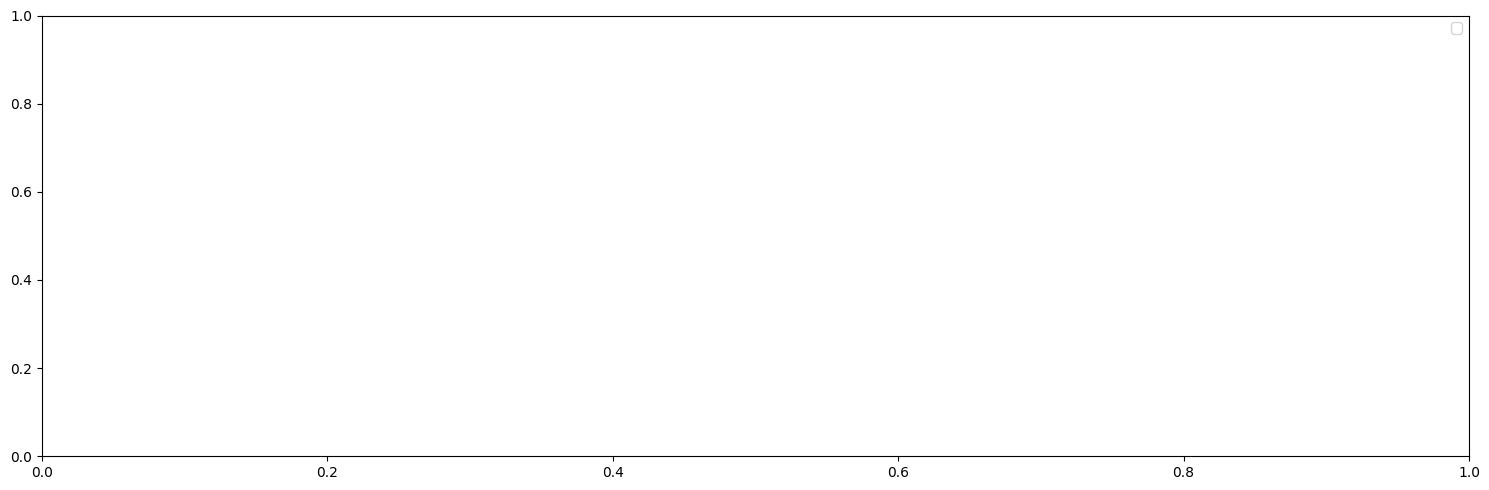

In [4]:
# Plot one example from the dataset to check that the dataset is correct
plt.figure(figsize=(15,5))
for i in range(1): # just one example
    # Get a random sample from dataset
    idx = np.random.randint(len(dataset))
    x, y = dataset[idx]
    
    # Split the data back into all the original arrays
    arrays = x.reshape(len(exponents_list), 2, n)

    # Extract individual arrays from the reshaped data, in a list
    arrays = [arrays[i][j] for i in range(len(exponents_list)) for j in range(2)]
    
    # Extract shifts
    
    
    # Plot all arrays on the same row
    for i, arr in enumerate(arrays):
        continue # TODO: plot all arrays on the same row

    # TODO: Plot the output array
    plt.legend()

plt.tight_layout()
plt.show()


In [5]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdditionOfAdditionsArray(n, exponents_list).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
n_epochs = 3000
losses = []
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)  # Add this line to store the average loss

    # Plot results
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}')
        model.eval()
        with torch.no_grad():
            # Get two random examples
            idx1, idx2 = np.random.randint(0, len(arrays), 2)
            x = torch.cat([torch.FloatTensor(arrays[idx1]), 
                          torch.FloatTensor(arrays[idx2])]).to(device)
            output = model(x).cpu().numpy()
            target = arrays[(shifts[idx1] + shifts[idx2]) % n]
            
            fig, ax = plt.subplots(1, 1, figsize=(3, 3))
            ax.plot(output, label='Output')
            ax.plot(target, '--', label='Target')
            ax.set_title('Output vs Target')
            ax.legend()
            plt.tight_layout()
            plt.show()

KeyboardInterrupt: 

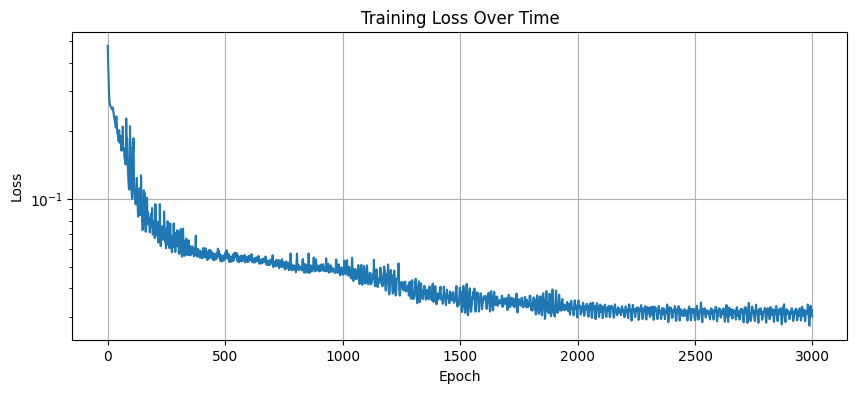

In [6]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # Using log scale since loss typically decreases exponentially
plt.grid(True)
plt.show()

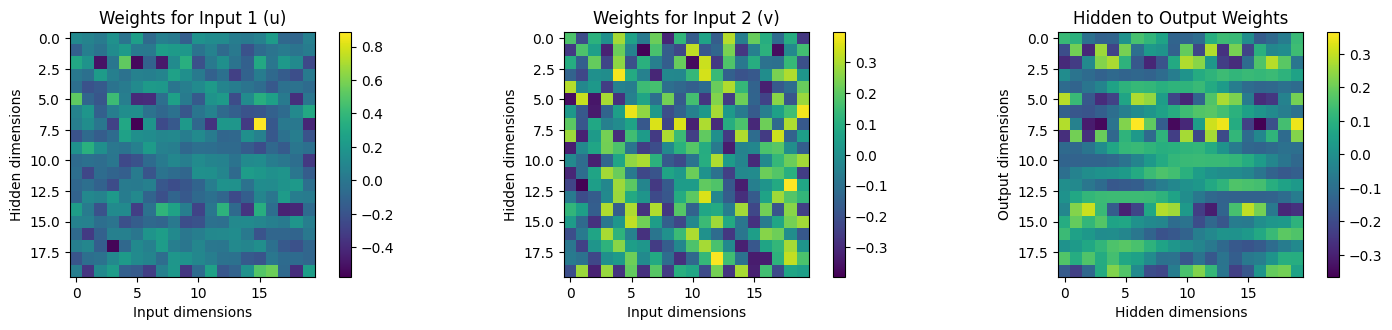

In [7]:
# Get the model weights
weights = []
for name, param in model.named_parameters():
    if 'weight' in name:
        weights.append(param.detach().cpu().numpy())

# Create figure with subplots for heatmaps
plt.figure(figsize=(15, 6))

# Plot weights for first input array - heatmap
plt.subplot(231)
plt.imshow(weights[0][:,:n], cmap='viridis')
plt.colorbar()
plt.title('Weights for Input 1 (u)')
plt.xlabel('Input dimensions')
plt.ylabel('Hidden dimensions')

# Plot weights for second input array - heatmap
plt.subplot(232)
plt.imshow(weights[0][:,n:], cmap='viridis')
plt.colorbar()
plt.title('Weights for Input 2 (v)')
plt.xlabel('Input dimensions')
plt.ylabel('Hidden dimensions')

# Plot weights from hidden to output - heatmap
plt.subplot(233)
plt.imshow(weights[1].T, cmap='viridis')
plt.colorbar()
plt.title('Hidden to Output Weights')
plt.xlabel('Hidden dimensions')
plt.ylabel('Output dimensions')

plt.tight_layout()


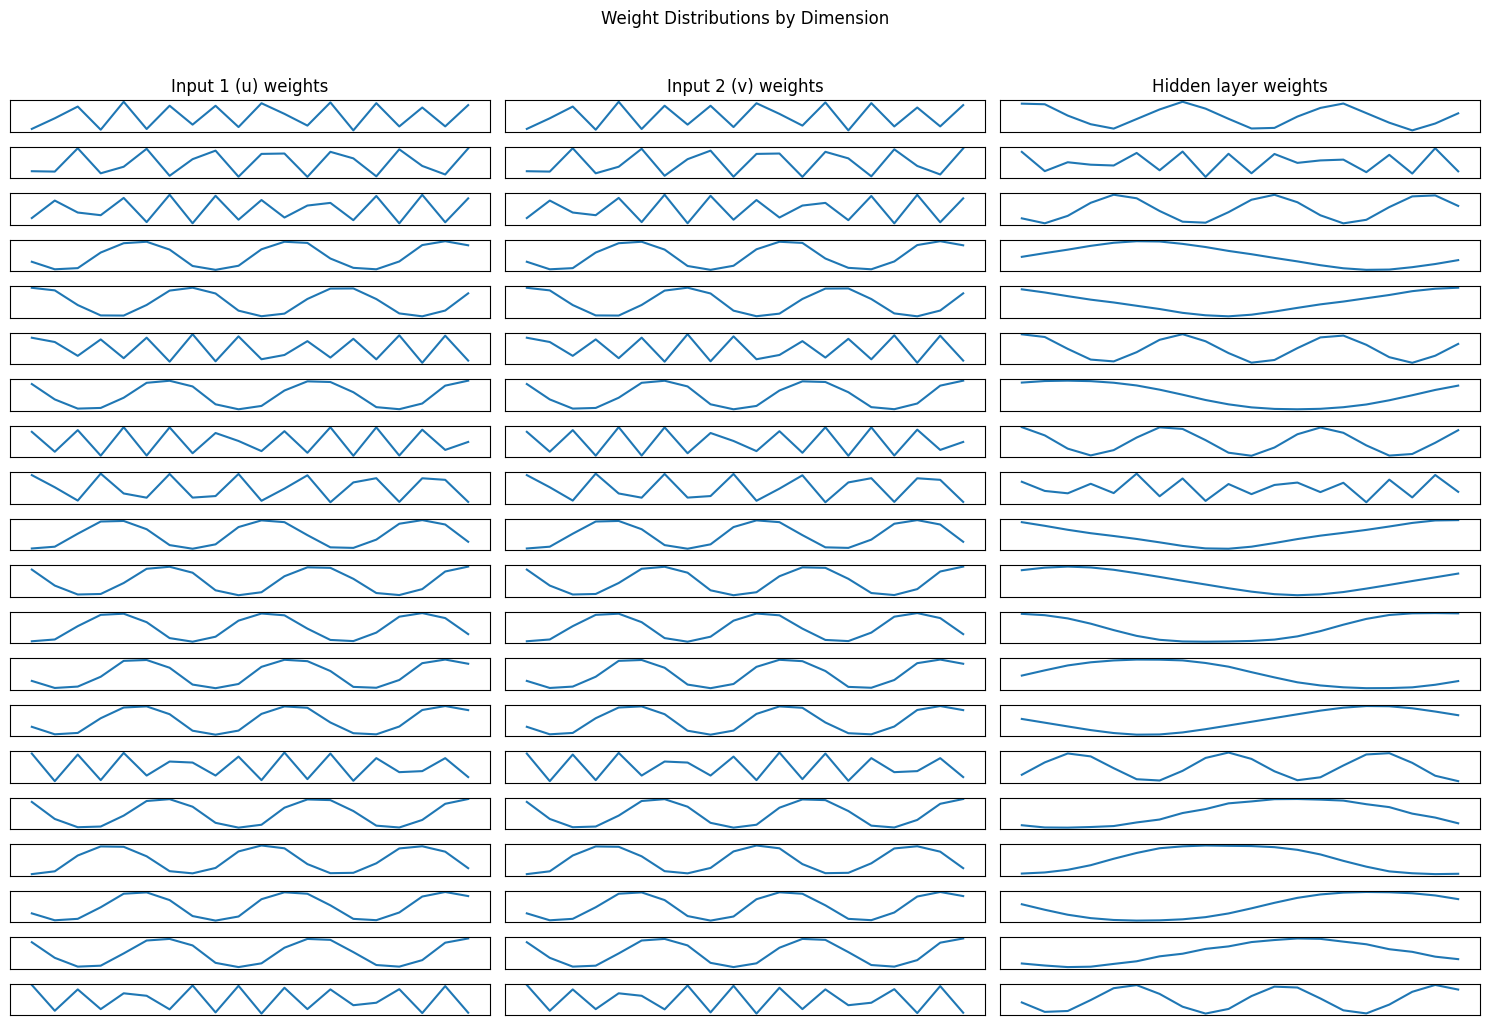

In [8]:
# Create figure with subplots for line plots
fig, axes = plt.subplots(20, 3, figsize=(15, 10))
fig.suptitle('Weight Distributions by Dimension', y=1.02)

# Plot each dimension as a line plot
for i in range(20):
    # Plot weights for first input array
    axes[i,0].plot(arrays @ weights[0][i,n:])
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    # Plot weights for second input array
    axes[i,1].plot(arrays @ weights[0][i,n:])
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    
    # Plot weights from hidden to output
    axes[i,2].plot(arrays @ weights[1][:,i])
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])

# Add column labels at the top
axes[0,0].set_title('Input 1 (u) weights')
axes[0,1].set_title('Input 2 (v) weights') 
axes[0,2].set_title('Hidden layer weights')

plt.tight_layout()
plt.show()

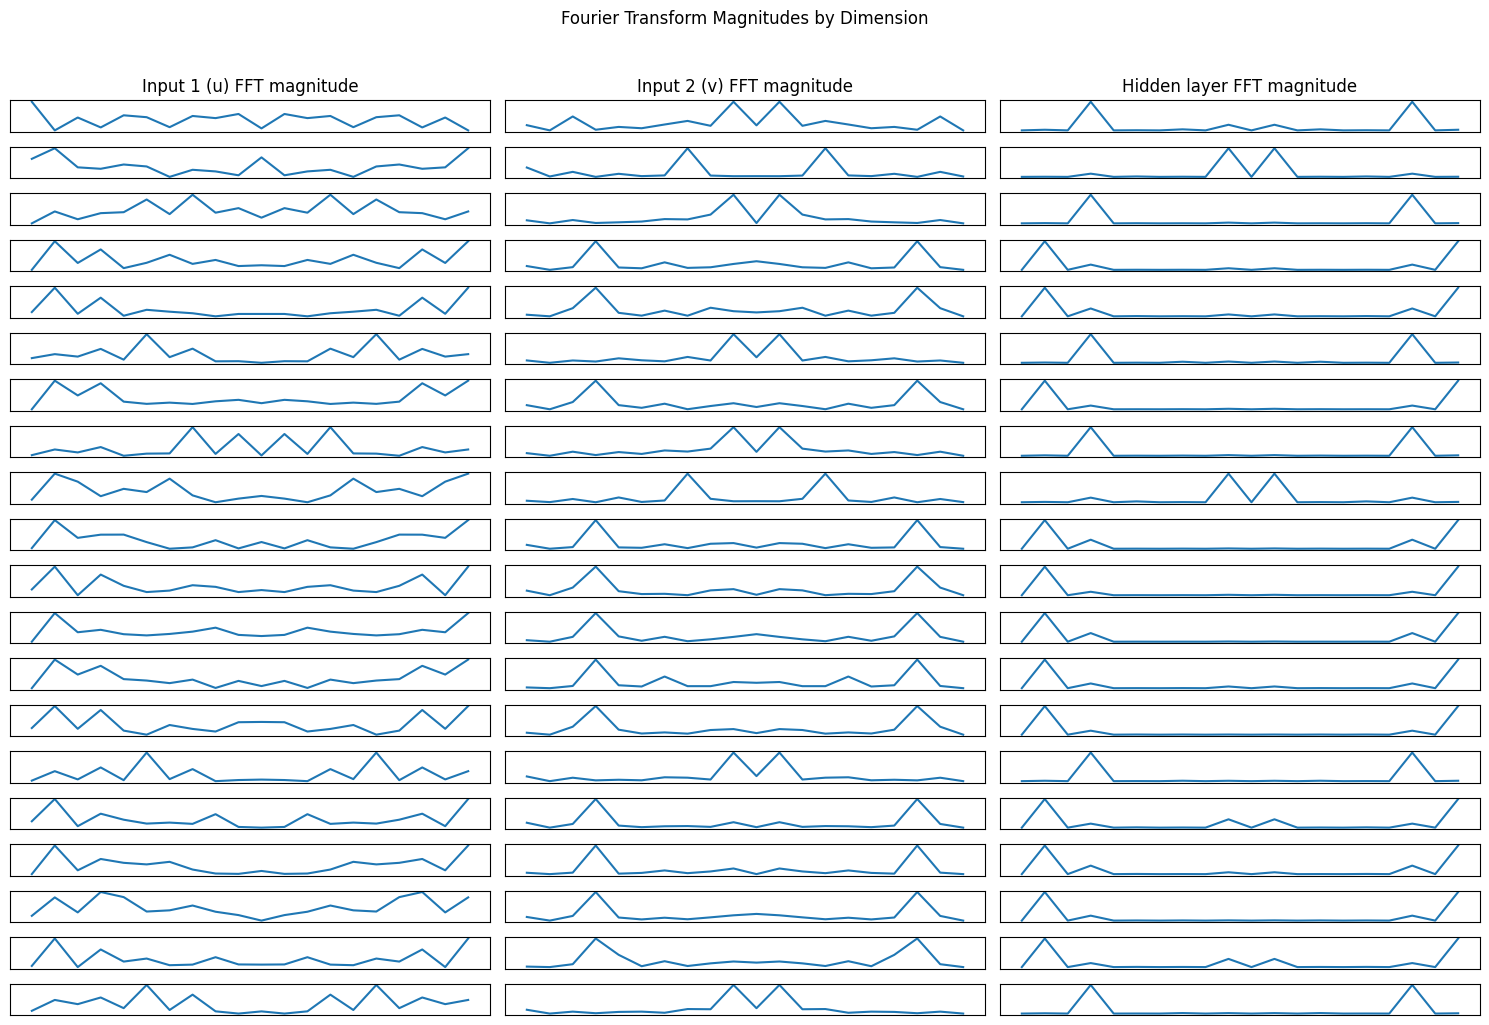

In [9]:
# Create figure with subplots for FFT magnitude plots
fig, axes = plt.subplots(20, 3, figsize=(15, 10))
fig.suptitle('Fourier Transform Magnitudes by Dimension', y=1.02)

# Plot FFT magnitude for each dimension
for i in range(20):
    # FFT for first input array weights
    fft_u = np.abs(np.fft.fft(weights[0][i,:n]))
    axes[i,0].plot(fft_u)
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    # FFT for second input array weights
    fft_v = np.abs(np.fft.fft(weights[0][i,n:]))
    axes[i,1].plot(fft_v)
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    
    # FFT for hidden to output weights
    fft_h = np.abs(np.fft.fft(weights[1][:,i]))
    axes[i,2].plot(fft_h)
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])

# Add column labels at the top
axes[0,0].set_title('Input 1 (u) FFT magnitude')
axes[0,1].set_title('Input 2 (v) FFT magnitude')
axes[0,2].set_title('Hidden layer FFT magnitude')

plt.tight_layout()
plt.show()
